In [178]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from itertools import cycle, islice

In [215]:
def get_membrane_blebbing_data(experiment_folder, istest=False):
    """generate box plot to compare conditions or summarize experiment"""
    subdirs = os.listdir(experiment_folder);
    experiment_title = os.path.basename(experiment_folder)
    if not all(["output" in dirname for dirname in subdirs]):
        condition_labels = subdirs;
    else:
        condition_labels = [experiment_title];
    dfs = []
    for condition in condition_labels:
        if (len(condition_labels) == 1) and condition_labels[0] == experiment_title:
            data_folder = experiment_folder;
        else:
            data_folder = os.path.join(experiment_folder, condition);
        for subfolder in os.listdir(data_folder):
            df = pd.read_csv(os.path.join(data_folder, subfolder, "Intensity ratios.csv"));
            df['output_folder'] = subfolder;
            df['Condition'] = condition;
            if istest:
                df['outer/inner'] = np.random.normal(loc=df['outer/inner'], scale=df['outer/inner'].std())
            dfs.append(df);
    conditionwise_data = pd.concat(dfs, ignore_index=True);
    return conditionwise_data
        
def color_cycle(base_list_of_colors=['r', 'g', 'b', 'y', 'm', 'c'], l=6):
    """Return a list of colors of length l, looping where necessary"""
    return list(islice(cycle(base_list_of_colors), None, l));

def plot_time_dependence_by_condition(df):
    """generate line plot showing evolution of intensity ration with time, per condition"""
    conditions = df['Condition'].unique();
    clrs = color_cycle(l=len(conditions));
    ax = df.groupby(['Condition', 'Frame']).median()['outer/inner'].unstack(level=0).plot(color=clrs);
    ax.set_ylabel("Actin intensity ratio");
    for idx, condition in enumerate(conditions):
        ax.fill_between(df.groupby('Frame')['Frame'].mean(), 
                    df.groupby(['Condition', 'Frame']).quantile(0.25)['outer/inner'].unstack(level=0)[condition], 
                    df.groupby(['Condition', 'Frame']).quantile(0.75)['outer/inner'].unstack(level=0)[condition], 
                    color=clrs[idx], alpha=0.2)
    ax.set_title("Time evolution of actin intensity ratios");
    box = ax.get_position();
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height]);
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

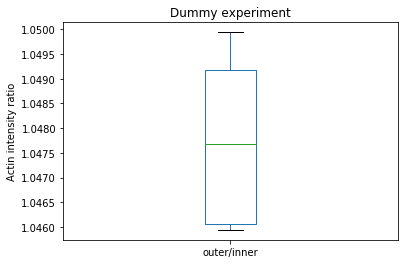

In [217]:
# test
experiment_folder = "D:\\data\\Joyce data test\\Dummy experiment"
df = get_membrane_blebbing_data(experiment_folder, istest=True);
ax = df.groupby('output_folder').mean().boxplot(column='outer/inner', grid=False)
ax.set_ylabel("Actin intensity ratio");
ax.set_title(os.path.basename(experiment_folder));


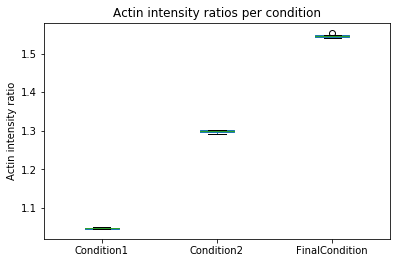

In [218]:
# test2
experiment_folder = "D:\\data\\Joyce data test\\Dummy experiment 2";
df = get_membrane_blebbing_data(experiment_folder, istest=True);
#print(df)
summary = df.groupby('output_folder').mean();
sub = df.drop_duplicates('output_folder');
summary['Condition'] = sub.set_index('output_folder')['Condition'];
ax = summary.boxplot(column='outer/inner', by='Condition', grid=False);
ax.set_ylabel("Actin intensity ratio");
ax.set_xlabel('');
plt.suptitle('')
ax.set_title("Actin intensity ratios per condition");

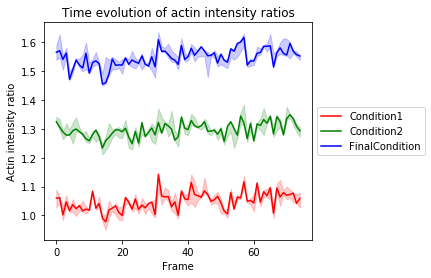

In [219]:
# test3   
experiment_folder = "D:\\data\\Joyce data test\\Dummy experiment 2"
df = get_membrane_blebbing_data(experiment_folder, istest=True);
plot_time_dependence_by_condition(df)

#df.groupby(['Condition', 'Frame']).quantile(0.25)['outer/inner'].unstack(level=0).plot(ax=ax, alpha=0.4, color=['r', 'g', 'b'], legend=False);
#df.groupby(['Condition', 'Frame']).quantile(0.75)['outer/inner'].unstack(level=0).plot(ax=ax, alpha=0.4, color=['r', 'g', 'b'], legend=False);

